In [22]:
import torch
from torch import Tensor
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time
from datetime import datetime as dt
import decouple
import math
import warnings

# .py file imports
import Performance_Stats as ps
import Data_Prep as dp
from Loss_Fcn import abs_softmax, sharpe_loss
import Train_Test as TT
from Models import LSTM_port, GRU_port, Transformer_port

warnings.filterwarnings('ignore')

In [23]:
#torch.arange(30).unsqueeze(1)
position = torch.arange(30).unsqueeze(1) # determines position from 1:seq_len
div_term = torch.exp(torch.arange(0, 512, 2) * (-math.log(10000.0) / 512))
pe = torch.zeros(30, 1, 512)  
pe[:, 0, 0::2] = torch.sin(position * div_term) 
pe[:, 0, 1::2] = torch.cos(position * div_term) 


In [24]:
# load data
config = decouple.AutoConfig(' ')
path = config('PATH_MY_MAIN_DATA')
tickers = pd.read_csv(path+'/_data_vol_tickers')
tickers = list(tickers.iloc[:, 1])
print(len(tickers))

data = pd.read_csv(path+'/_data_set_vol', index_col='date', parse_dates=True)
data = dp.reduce_features(data, ['IvMean90', 'IvMean120', 'ticker'])
pd.options.display.max_columns = None
data.head()

315


IvMean60_A  IvMean360_A  Phv10_A  Phv60_A  IvMeanSkew10_A  \
date                                                                    
2007-11-01      0.3451       0.3224   0.2653   0.1952          0.0475   
2007-11-02      0.3396       0.3256   0.2665   0.1965          0.0452   
2007-11-05      0.3406       0.3267   0.2566   0.1989          0.0866   
2007-11-06      0.3291       0.3249   0.2219   0.1997          0.0188   
2007-11-07      0.3466       0.3294   0.2429   0.2044          0.0155   

            IvMeanSkew60_A  IvMeanSkew360_A  return_A  norm_adjclose_A  \
date                                                                     
2007-11-01          0.0424           0.0170 -0.016271        82.409091   
2007-11-02          0.0722           0.0166 -0.006663        81.863636   
2007-11-05          0.0880           0.0175 -0.009246        81.113636   
2007-11-06          0.0384           0.0155  0.012178        82.113636   
2007-11-07          0.0756           0.0162 -0.029638        79.750000   

            norm_adj_range_pct_A  volume_dollars_MM_A  IvMean60_return_next_A  \
date                                                                            
2007-11-01              0.022634              70.4720               -0.015937   
2007-11-02              0.025309              47.6393                0.002945   
2007-11-05              0.023655              75.8815               -0.033764   
2007-11-06              0.024029              79.4667                0.053175   
2007-11-07              0.031996              75.7568                0.038373   

            IvMean60_return_prev_A  IvMean60_return_ten_next_A  IvMean60_AAP  \
date                                                                           
2007-11-01                     NaN                    0.018835        0.3259   
2007-11-02               -0.015937                   -0.159894        0.3283   
2007-11-05                0.002945                   -0.141809        0.3418   
2007-11-06               -0.033764                   -0.154968        0.3236   
2007-11-07                0.053175                   -0.161858        0.3437   

            IvMean360_AAP  Phv10_AAP  Phv60_AAP  IvMeanSkew10_AAP  \
date                                                                
2007-11-01         0.3312     0.3865     0.3035            0.0302   
2007-11-02         0.3471     0.3352     0.3072            0.0311   
2007-11-05         0.3469     0.3788     0.3155            0.0122   
2007-11-06         0.3457     0.4065     0.3167            0.0354   
2007-11-07         0.3461     0.4091     0.3168            0.0260   

            IvMeanSkew60_AAP  IvMeanSkew360_AAP  return_AAP  \
date                                                          
2007-11-01            0.0307             0.0203    0.026811   
2007-11-02            0.0314             0.0272   -0.008051   
2007-11-05            0.0138             0.0263    0.010526   
2007-11-06            0.0356             0.0403    0.036458   
2007-11-07            0.0266             0.0247   -0.008013   

            norm_adjclose_AAP  norm_adj_range_pct_AAP  volume_dollars_MM_AAP  \
date                                                                           
2007-11-01         255.082845                0.058286               245.0139   
2007-11-02         253.045674                0.036568                90.0410   
2007-11-05         255.737649                0.055003               117.8234   
2007-11-06         265.414209                0.049460                86.2215   
2007-11-07         263.304283                0.022039                73.2562   

            IvMean60_return_next_AAP  IvMean60_return_prev_AAP  \
date                                                             
2007-11-01                  0.007364                       NaN   
2007-11-02                  0.041121                  0.007364   
2007-11-05                 -0.053248                  0.041121   
2007-11-06                  0.06211

In [16]:
iv_cols = []
rv_cols = []
for c in data.columns:
    if ('IvMean60_' in c) & (len(c) < 15):
        iv_cols.append(c)
    elif 'Phv10' in c:
        rv_cols.append(c)

In [22]:
df_iv = data[iv_cols]
df_rv = data[rv_cols]
print(df_iv.mean().mean(), df_rv.mean().mean())

0.3029851384835406 0.2519978553551682


In [8]:
for c in data.columns:
    print(c)

IvMean60_A
IvMean360_A
Phv10_A
Phv60_A
IvMeanSkew10_A
IvMeanSkew60_A
IvMeanSkew360_A
return_A
norm_adjclose_A
norm_adj_range_pct_A
volume_dollars_MM_A
IvMean60_return_next_A
IvMean60_return_prev_A
IvMean60_return_ten_next_A
IvMean60_AAP
IvMean360_AAP
Phv10_AAP
Phv60_AAP
IvMeanSkew10_AAP
IvMeanSkew60_AAP
IvMeanSkew360_AAP
return_AAP
norm_adjclose_AAP
norm_adj_range_pct_AAP
volume_dollars_MM_AAP
IvMean60_return_next_AAP
IvMean60_return_prev_AAP
IvMean60_return_ten_next_AAP
IvMean60_AAPL
IvMean360_AAPL
Phv10_AAPL
Phv60_AAPL
IvMeanSkew10_AAPL
IvMeanSkew60_AAPL
IvMeanSkew360_AAPL
return_AAPL
norm_adjclose_AAPL
norm_adj_range_pct_AAPL
volume_dollars_MM_AAPL
IvMean60_return_next_AAPL
IvMean60_return_prev_AAPL
IvMean60_return_ten_next_AAPL
IvMean60_ABC
IvMean360_ABC
Phv10_ABC
Phv60_ABC
IvMeanSkew10_ABC
IvMeanSkew60_ABC
IvMeanSkew360_ABC
return_ABC
norm_adjclose_ABC
norm_adj_range_pct_ABC
volume_dollars_MM_ABC
IvMean60_return_next_ABC
IvMean60_return_prev_ABC
IvMean60_return_ten_next_ABC
IvMean

In [10]:
torch.manual_seed(109)

batch_size = 32
lookback = 30
iv = 60

df_train, df_val, df_test = dp.train_val_test(data, lookback, train_years=6) 

train_dataset = dp.TS_Dataset(df_train, lookback=lookback, iv=iv)
val_dataset = dp.TS_Dataset(df_val, lookback=lookback, iv=iv)
test_dataset = dp.TS_Dataset(df_test, lookback=lookback, iv=iv)

train_loader = DataLoader(train_dataset,
                          batch_size=batch_size,
                          shuffle=True)

val_loader = DataLoader(val_dataset,
                        batch_size=batch_size,
                        shuffle=False)

test_loader = DataLoader(test_dataset,
                         batch_size=batch_size,
                         shuffle=False)

X, y = next(iter(train_loader))

print("Features shape:", X.shape)
print("Target shape:", y.shape)



Features shape: torch.Size([32, 30, 3150])
Target shape: torch.Size([32, 315])


In [ ]:
# hyperparam testing
lr = 0.0001
num_hidden_units = 512
iv=60
out_feats = 315
num_sensors = 11 * out_feats
lookback = 30

min_val_loss = []
time = []

model = LSTM_port(num_sensors=num_sensors,
                  hidden_units=num_hidden_units,
                  out_feats=out_feats)

loss_function = sharpe_loss
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

train_losses = []
val_losses = []
t0 = dt.now()
for epoch in range(100):
    t00 = dt.now()
    print(f"Epoch {epoch}\n---------")
    train_loss = TT.train_model(train_loader, model, loss_function, optimizer=optimizer)
    train_losses.append(train_loss)
    val_loss = TT.test_model(val_loader, model, loss_function)
    val_losses.append(val_loss)
    t01 = dt.now()
    T1 = (t01 - t00).total_seconds()
    print('Train loss: {}'.format(train_loss))
    print('Validation loss: {}'.format(val_loss))
    print('Time to train: {} seconds'.format(T1))
    print()
        
    if TT.early_stop(val_losses, tolerance=100):
        print('Early Stop Triggered')
        break
val_losses.sort()        
x = val_losses
x = np.mean(x[:5])
min_val_loss.append(x)
t1 = dt.now()
T = (t1 - t0).total_seconds()
time.append(T)
print('Time to train: {} seconds'.format(T))

print('Total time: {} seconds'.format(np.sum(time)))


In [5]:
dp.get_features(df_train).shape[1]

3465

In [5]:
# test model
torch.manual_seed(109)
lr = 0.0001
num_hidden_units = 512
iv=60
out_feats = 315
num_sensors = 11 * out_feats
lookback = 30
batch_size = 32

min_val_loss = []
time = []

model = GRU_port(num_sensors=num_sensors,
                  hidden_units=num_hidden_units,
                 out_feats=out_feats)
loss_function = sharpe_loss
optimizer = torch.optim.Adam(model.parameters(), lr=lr)


# loop through different time periods
df_predictions = pd.DataFrame()
test_losses = []
benchmark_returns = []
benchmark_sharpe = []
portfolio_returns = []
portfolio_sharpe = []
for i in range(9): # should be 9
    t0 = dt.now()
    df_train, df_val, df_test = dp.train_val_test(data, lookback, train_years=5+i) 

    train_dataset = dp.TS_Dataset(df_train, lookback=lookback, iv=iv)
    val_dataset = dp.TS_Dataset(df_val, lookback=lookback, iv=iv)
    test_dataset = dp.TS_Dataset(df_test, lookback=lookback, iv=iv)

    # Should I shuffle data for models with memory? RNN order matters
    train_loader = DataLoader(train_dataset,
                              batch_size=batch_size,
                              shuffle=True)

    val_loader = DataLoader(val_dataset,
                            batch_size=batch_size,
                            shuffle=False)

    test_loader = DataLoader(test_dataset,
                             batch_size=batch_size,
                             shuffle=False)


    train_losses = []
    val_losses = []
    for epoch in range(100):
        print(f"Epoch {epoch}\n---------")
        train_loss = TT.train_model(train_loader, model, loss_function, optimizer=optimizer)
        train_losses.append(train_loss)
        val_loss = TT.test_model(val_loader, model, loss_function)
        val_losses.append(val_loss)
    
        if TT.early_stop(val_losses, tolerance=100):
            print('Early Stop Triggered')
            break
    
        print('Train loss: {}'.format(train_loss))
        print('Validation loss: {}'.format(val_loss))
        print()
    test_loss = TT.test_model(test_loader, model, loss_function)
    test_losses.append(test_loss)
    
    df_int = TT.get_pred_df_sharpe(df_train,
                                df_test,
                                model=model,
                                batch_size=batch_size,
                                num_assets=315,
                                lookback=lookback,
                                iv=iv,
                                tickers=tickers,
                                test_only=True)
    df_predictions = pd.concat([df_predictions, df_int]).sort_index(ascending=True)
    
    bm_r = ps.total_return(df_int['return_benchmark'][1:])
    bm_s = ps.sharpe_ratio(df_int['return_benchmark'][1:])
    p_r = ps.total_return(df_int['return_portfolio'][1:])
    p_s = ps.sharpe_ratio(df_int['return_portfolio'][1:])
    
    benchmark_returns.append(bm_r)
    benchmark_sharpe.append(bm_s)
    portfolio_returns.append(p_r)
    portfolio_sharpe.append(p_s)
    
    t1 = dt.now()
    T = (t1 - t0).total_seconds()
    print()
    print('Test loss: {} Portfolio return: {}, Portfolio Sharpe: {}'.format(test_loss, p_r, p_s))
    print('Benchmark return: {}, Benchmark Sharpe: {}'.format(bm_r, bm_s))
    
    print('Total seconds to train:  {}'.format(T))




Epoch 0
---------
Train loss: -0.03542379988175526
Validation loss: -0.13327954639680684

Epoch 1
---------
Train loss: -0.1968279164750129
Validation loss: -0.15667327778646722

Epoch 2
---------
Train loss: -0.39881133409217
Validation loss: -0.16965880594216287

Epoch 3
---------
Train loss: -0.5299428023397923
Validation loss: -0.10463756462559104

Epoch 4
---------
Train loss: -0.6908716604113578
Validation loss: -0.14995574112981558

Epoch 5
---------
Train loss: -0.9280708223581314
Validation loss: -0.24611134454607964

Epoch 6
---------
Train loss: -0.973413833975792
Validation loss: -0.2556819077581167

Epoch 7
---------
Train loss: -1.0809062354266643
Validation loss: -0.22787166922353208

Epoch 8
---------
Train loss: -1.2699109345674515
Validation loss: -0.22842395957559347

Epoch 9
---------
Train loss: -1.2867251291871071
Validation loss: -0.27540161134675145

Epoch 10
---------
Train loss: -1.4650676473975182
Validation loss: -0.2325445027090609

Epoch 11
---------
Train

Train loss: -4.777450275421143
Validation loss: -0.3315697992220521

Epoch 94
---------
Train loss: -4.735535448789596
Validation loss: -0.32854922526166774

Epoch 95
---------
Train loss: -4.8439457505941395
Validation loss: -0.35716193029657006

Epoch 96
---------
Train loss: -5.267254942655564
Validation loss: -0.35013662761775777

Epoch 97
---------
Train loss: -5.184091407060623
Validation loss: -0.3471903773024678

Epoch 98
---------
Train loss: -5.764107519388199
Validation loss: -0.3501163050532341

Epoch 99
---------
Train loss: -5.059257221221924
Validation loss: -0.33857674920000136


Test loss: -0.24801157042384148 Portfolio return: 0.3246779214457338, Portfolio Sharpe: 3.6277271497445085
Benchmark return: 0.27001967865155097, Benchmark Sharpe: 0.7313631272116509
Total seconds to train:  1310.000051
Epoch 0
---------
Train loss: -2.178151840964953
Validation loss: -0.17919310042634606

Epoch 1
---------
Train loss: -2.490260453273853
Validation loss: -0.19712313078343868

E

Train loss: -6.393443306287129
Validation loss: -0.16020255722105503

Epoch 84
---------
Train loss: -5.593293319145839
Validation loss: -0.18361513502895832

Epoch 85
---------
Train loss: -6.404691139856975
Validation loss: -0.1690506311133504

Epoch 86
---------
Train loss: -5.891343812147777
Validation loss: -0.1924004638567567

Epoch 87
---------
Train loss: -5.8647505864501
Validation loss: -0.17257925122976303

Epoch 88
---------
Train loss: -5.970110689600308
Validation loss: -0.19200858008116484

Epoch 89
---------
Train loss: -5.824095596869786
Validation loss: -0.18877676036208868

Epoch 90
---------
Train loss: -6.216035480300586
Validation loss: -0.18791277799755335

Epoch 91
---------
Train loss: -6.345148449142774
Validation loss: -0.19108545407652855

Epoch 92
---------
Train loss: -6.055009685456753
Validation loss: -0.2034628428518772

Epoch 93
---------
Train loss: -5.831853886445363
Validation loss: -0.20823500398546457

Epoch 94
---------
Train loss: -6.54315293331

Train loss: -3.1179295235446522
Validation loss: -0.21855170345224906

Epoch 74
---------
Train loss: -2.5668439077479497
Validation loss: -0.20800637500360608

Epoch 75
---------
Train loss: -3.0754394999572208
Validation loss: -0.21164308837614954

Epoch 76
---------
Train loss: -2.1919382714799474
Validation loss: -0.18838333385065198

Epoch 77
---------
Train loss: -0.8463143328470843
Validation loss: -0.10109346627723426

Epoch 78
---------
Train loss: -0.8763832210430077
Validation loss: -0.13001908850856125

Epoch 79
---------
Train loss: -1.210507603628295
Validation loss: -0.1644825106486678

Epoch 80
---------
Train loss: -1.5674136999462331
Validation loss: -0.18760532140731812

Epoch 81
---------
Train loss: -1.3067719489336014
Validation loss: -0.19060190953314304

Epoch 82
---------
Train loss: -1.7420467734336853
Validation loss: -0.21975008584558964

Epoch 83
---------
Train loss: -2.060220037187849
Validation loss: -0.21404075250029564

Epoch 84
---------
Train loss: -

Train loss: -5.245259392829168
Validation loss: -0.15999182756058872

Epoch 64
---------
Train loss: -5.243474487274412
Validation loss: -0.1509920681855874

Epoch 65
---------
Train loss: -5.74928319264972
Validation loss: -0.1539406376250554

Epoch 66
---------
Train loss: -5.072218628156753
Validation loss: -0.17551409371662885

Epoch 67
---------
Train loss: -5.919573149983845
Validation loss: -0.16722359682898968

Epoch 68
---------
Train loss: -5.287664229907687
Validation loss: -0.16137830214574933

Epoch 69
---------
Train loss: -5.5579057354775685
Validation loss: -0.15028479206375778

Epoch 70
---------
Train loss: -5.553498763886709
Validation loss: -0.1702248336514458

Epoch 71
---------
Train loss: -5.29949468847305
Validation loss: -0.1452768836170435

Epoch 72
---------
Train loss: -5.512288598787217
Validation loss: -0.17982941400259733

Epoch 73
---------
Train loss: -5.750470369581192
Validation loss: -0.18151480238884687

Epoch 74
---------
Train loss: -5.56433425441

Train loss: -7.5748894953391925
Validation loss: -0.4566233796067536

Epoch 55
---------
Train loss: -7.090291543745659
Validation loss: -0.44082345161587

Epoch 56
---------
Train loss: -7.498380276518808
Validation loss: -0.4224499240517616

Epoch 57
---------
Train loss: -7.3944487806776875
Validation loss: -0.44331225426867604

Epoch 58
---------
Train loss: -7.292713685774467
Validation loss: -0.41951979603618383

Epoch 59
---------
Train loss: -7.8643436028923785
Validation loss: -0.4192427219823003

Epoch 60
---------
Train loss: -7.170698881149292
Validation loss: -0.44714378751814365

Epoch 61
---------
Train loss: -7.828006428731999
Validation loss: -0.44939707685261965

Epoch 62
---------
Train loss: -7.67024036528359
Validation loss: -0.42501931614242494

Epoch 63
---------
Train loss: -7.7702469288463325
Validation loss: -0.39929322712123394

Epoch 64
---------
Train loss: -7.395849056646857
Validation loss: -0.42612255923449993

Epoch 65
---------
Train loss: -8.233456554

Train loss: -8.00297726256938
Validation loss: -0.3167958692647517

Epoch 46
---------
Train loss: -7.746529721006563
Validation loss: -0.2770350628707092

Epoch 47
---------
Train loss: -8.204515698589857
Validation loss: -0.28799370559863746

Epoch 48
---------
Train loss: -7.1249581650842595
Validation loss: -0.3003250933252275

Epoch 49
---------
Train loss: -7.937907119340535
Validation loss: -0.2901618434698321

Epoch 50
---------
Train loss: -7.824971346915523
Validation loss: -0.3038127631880343

Epoch 51
---------
Train loss: -7.872998282879213
Validation loss: -0.30430086428532377

Epoch 52
---------
Train loss: -8.274027293241478
Validation loss: -0.30257835565134883

Epoch 53
---------
Train loss: -7.304439974736564
Validation loss: -0.28945640940219164

Epoch 54
---------
Train loss: -7.96602301054363
Validation loss: -0.2917908725794405

Epoch 55
---------
Train loss: -7.997199634962444
Validation loss: -0.2876929845660925

Epoch 56
---------
Train loss: -8.75521414792990

Train loss: -8.101980639600205
Validation loss: -0.2752066543325782

Epoch 37
---------
Train loss: -7.516952440656465
Validation loss: -0.2862181691452861

Epoch 38
---------
Train loss: -7.901982674653503
Validation loss: -0.2766029676422477

Epoch 39
---------
Train loss: -8.554728198325497
Validation loss: -0.263324489351362

Epoch 40
---------
Train loss: -8.231892355557147
Validation loss: -0.2811926305294037

Epoch 41
---------
Train loss: -8.357219230169537
Validation loss: -0.28183864895254374

Epoch 42
---------
Train loss: -8.4991156479408
Validation loss: -0.28114596568048

Epoch 43
---------
Train loss: -8.792552912372281
Validation loss: -0.26428417954593897

Epoch 44
---------
Train loss: -8.572384129995587
Validation loss: -0.26295086182653904

Epoch 45
---------
Train loss: -8.689568138670648
Validation loss: -0.2685707123018801

Epoch 46
---------
Train loss: -8.99786571524609
Validation loss: -0.2884825300425291

Epoch 47
---------
Train loss: -8.513710602946665
Vali

Train loss: -8.288336874309339
Validation loss: -0.23911915719509125

Epoch 28
---------
Train loss: -8.17026313229611
Validation loss: -0.2452775277197361

Epoch 29
---------
Train loss: -8.712890529632569
Validation loss: -0.23775168508291245

Epoch 30
---------
Train loss: -8.252234888076782
Validation loss: -0.20920848147943616

Epoch 31
---------
Train loss: -8.282319738990383
Validation loss: -0.2412579171359539

Epoch 32
---------
Train loss: -8.798484327918604
Validation loss: -0.2562990551814437

Epoch 33
---------
Train loss: -8.368117367593866
Validation loss: -0.255896994844079

Epoch 34
---------
Train loss: -9.244680008135344
Validation loss: -0.24621111061424017

Epoch 35
---------
Train loss: -8.606491041183471
Validation loss: -0.2457475857809186

Epoch 36
---------
Train loss: -9.003811728326898
Validation loss: -0.2297015623189509

Epoch 37
---------
Train loss: -8.386284301155492
Validation loss: -0.22635248396545649

Epoch 38
---------
Train loss: -9.37887704874339

Train loss: -5.286264250579389
Validation loss: -0.20563518349081278

Epoch 18
---------
Train loss: -6.024714506945564
Validation loss: -0.20344714354723692

Epoch 19
---------
Train loss: -5.7500763986874555
Validation loss: -0.2134283003397286

Epoch 20
---------
Train loss: -6.064435363973229
Validation loss: -0.2011829111725092

Epoch 21
---------
Train loss: -5.819750292208588
Validation loss: -0.20355512667447329

Epoch 22
---------
Train loss: -6.221864544650884
Validation loss: -0.2061567548662424

Epoch 23
---------
Train loss: -6.180728817738376
Validation loss: -0.19297335296869278

Epoch 24
---------
Train loss: -6.487461349339161
Validation loss: -0.2063484680838883

Epoch 25
---------
Train loss: -6.720534042825976
Validation loss: -0.21558002661913633

Epoch 26
---------
Train loss: -6.566184939111321
Validation loss: -0.20810605818405747

Epoch 27
---------
Train loss: -5.533006840792385
Validation loss: -0.23705263389274478

Epoch 28
---------
Train loss: -6.696023779

In [6]:
print(np.mean(portfolio_returns),
      np.mean(portfolio_sharpe),
      np.mean(benchmark_returns),
      np.mean(benchmark_sharpe))

0.37069316035887834 3.0121123552238687 0.28789521784296135 0.498903389737553


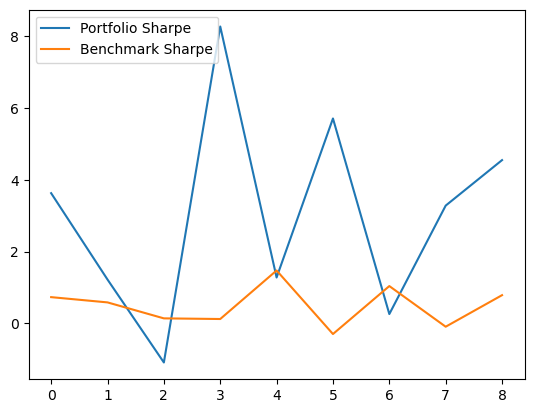

In [9]:
#TT.plot_returns(portfolio_returns, benchmark_returns)
TT.plot_returns(portfolio_sharpe, benchmark_sharpe, returns=False)

In [14]:
## Attn Model parameters
torch.manual_seed(109)
dim_val = 1024 # This can be any value divisible by n_heads. 512 is used in the original transformer paper.
n_heads = 4 # The number of attention heads (aka parallel attention layers). dim_val must be divisible by this number
n_decoder_layers = 2 # Number of times the decoder layer is stacked in the decoder
n_encoder_layers = 2 # Number of times the encoder layer is stacked in the encoder
input_size = 3150 # The number of input variables. 1 if univariate forecasting.
dec_seq_len = 30 # length of input given to decoder. Can have any integer value.
enc_seq_len = 30 # length of input given to encoder. Can have any integer value.
output_sequence_length = 1 # Length of the target sequence, i.e. how many time steps should your forecast cover
max_seq_len = enc_seq_len # What's the longest sequence the model will encounter? Used to make\ the positional encoder
num_predicted_features = 315

# Other Params
batch_size = 32
loss_function = sharpe_loss
lr = 0.00001
lookback=30
iv=60

min_val_loss = []
time = []

# loop through different time periods
df_predictions = pd.DataFrame()
test_losses = []
benchmark_returns = []
benchmark_sharpe = []
portfolio_returns = []
portfolio_sharpe = []
for i in range(9):
    t0 = dt.now()
    df_train, df_val, df_test = dp.train_val_test(data, lookback, train_years=5+i) 

    train_dataset = dp.TS_Dataset_attn(df_train, lookback=lookback, iv=iv)
    val_dataset = dp.TS_Dataset_attn(df_val, lookback=lookback, iv=iv)
    test_dataset = dp.TS_Dataset_attn(df_test, lookback=lookback, iv=iv)

    # Should I shuffle data for models with memory? RNN order matters
    train_loader = DataLoader(train_dataset,
                              batch_size=batch_size,
                              shuffle=True)

    val_loader = DataLoader(val_dataset,
                            batch_size=batch_size,
                            shuffle=False)

    test_loader = DataLoader(test_dataset,
                             batch_size=batch_size,
                             shuffle=False)
    
    model = Transformer_port(
        batch_first=True,
        dim_val=dim_val,
        input_size=input_size, 
        dec_seq_len=dec_seq_len,
        max_seq_len=max_seq_len,
        out_seq_len=output_sequence_length, 
        n_decoder_layers=n_decoder_layers,
        n_encoder_layers=n_encoder_layers,
        n_heads=n_heads, 
        num_predicted_features=num_predicted_features)
    
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)


    train_losses = []
    val_losses = []
    for epoch in range(50):
        print(f"Epoch {epoch}\n---------")
        train_loss = TT.train_model_attn(train_loader, model, loss_function, optimizer=optimizer)
        train_losses.append(train_loss)
        val_loss = TT.test_model_attn(val_loader, model, loss_function)
        val_losses.append(val_loss)
    
        if TT.early_stop(val_losses, tolerance=100):
            print('Early Stop Triggered')
            break
            
        print('Train loss: {}'.format(train_loss))
        print('Validation loss: {}'.format(val_loss))
        print()
    test_loss = TT.test_model_attn(test_loader, model, loss_function)
    test_losses.append(test_loss)
    
    df_int = TT.get_pred_df_sharpe_attn(df_train,
                                df_test,
                                model=model,
                                batch_size=batch_size,
                                lookback=lookback,
                                tickers=tickers,
                                num_assets=num_predicted_features,
                                iv=iv,
                                test_only=True)
    df_predictions = pd.concat([df_predictions, df_int]).sort_index(ascending=True)
    
    bm_r = ps.total_return(df_int['return_benchmark'])
    bm_s = ps.sharpe_ratio(df_int['return_benchmark'])
    p_r = ps.total_return(df_int['return_portfolio'])
    p_s = ps.sharpe_ratio(df_int['return_portfolio'])
    
    benchmark_returns.append(bm_r)
    benchmark_sharpe.append(bm_s)
    portfolio_returns.append(p_r)
    portfolio_sharpe.append(p_s)
    
    t1 = dt.now()
    T = (t1 - t0).total_seconds()
    print()
    print('Test loss: {} Portfolio return: {}, Portfolio Sharpe: {}'.format(test_loss, p_r, p_s))
    print('Benchmark return: {}, Benchmark Sharpe: {}'.format(bm_r, bm_s))
    
    print('Total seconds to train:  {}'.format(T))

Epoch 0
---------
Train loss: 0.02099991604918614
Validation loss: 0.015197641216218472

Epoch 1
---------
Train loss: -0.1327184895053506
Validation loss: -0.04751860469696112

Epoch 2
---------
Train loss: -0.27141575556015596
Validation loss: -0.09699971484951675

Epoch 3
---------
Train loss: -0.5318055234849453
Validation loss: -0.07489053811877966

Epoch 4
---------
Train loss: -0.609940505027771
Validation loss: -0.16728964471258223

Epoch 5
---------


KeyboardInterrupt: 

In [6]:
print(np.mean(portfolio_returns),
      np.mean(portfolio_sharpe),
      np.mean(benchmark_returns),
      np.mean(benchmark_sharpe))

0.5383200412729423 6.68287760022686 0.3043904680722147 0.5402283054446839


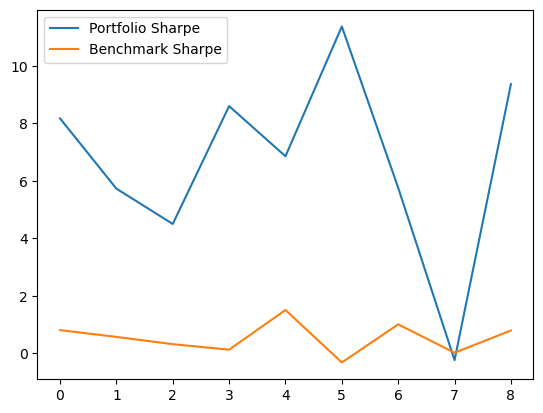

In [7]:
#TT.plot_returns(portfolio_returns, benchmark_returns)
TT.plot_returns(portfolio_sharpe, benchmark_sharpe, returns=False)

In [8]:
x = df_predictions
path = '/Users/dylanjorling/UCLA/mas_thesis/results/dfs'
name = '/Attn0203_01.csv'
x.to_csv(path_or_buf=path+name)

In [11]:
ps.total_return(x['return_benchmark'])

0.2629694242493581

In [28]:
torch.manual_seed(109)

batch_size = 32
lookback = 30
iv = 60

df_train, df_val, df_test = dp.train_val_test(data, lookback, train_years=6) 

train_dataset = dp.TS_Dataset_attn(df_train, lookback=lookback, iv=iv)
val_dataset = dp.TS_Dataset_attn(df_val, lookback=lookback, iv=iv)
test_dataset = dp.TS_Dataset_attn(df_test, lookback=lookback, iv=iv)

# Should I shuffle data for models with memory? RNN order matters
train_loader = DataLoader(train_dataset,
                            batch_size=batch_size,
                            shuffle=True)

val_loader = DataLoader(val_dataset,
                        batch_size=batch_size,
                        shuffle=False)

test_loader = DataLoader(test_dataset,
                        batch_size=batch_size,
                        shuffle=False)

X, y, trg = next(iter(train_loader))

print("Features shape:", X.shape)
print("Target shape:", y.shape)
print("trg shape:", trg.shape)


Features shape: torch.Size([32, 30, 3150])
Target shape: torch.Size([32, 315])
trg shape: torch.Size([32, 315])


In [30]:
dp.get_attn_targs(df_train)

,IvMean60_return_prev_A,IvMean60_return_prev_AAP,IvMean60_return_prev_AAPL,IvMean60_return_prev_ABC,IvMean60_return_prev_ABT,IvMean60_return_prev_ACN,IvMean60_return_prev_ADBE,IvMean60_return_prev_ADI,IvMean60_return_prev_ADM,IvMean60_return_prev_ADP,IvMean60_return_prev_ADSK,IvMean60_return_prev_AEP,IvMean60_return_prev_AES,IvMean60_return_prev_AFL,IvMean60_return_prev_AIZ,IvMean60_return_prev_AKAM,IvMean60_return_prev_ALB,IvMean60_return_prev_ALGN,IvMean60_return_prev_ALK,IvMean60_return_prev_ALL,IvMean60_return_prev_AMAT,IvMean60_return_prev_AMGN,IvMean60_return_prev_AMP,IvMean60_return_prev_AMT,IvMean60_return_prev_AMZN,IvMean60_return_prev_ANSS,IvMean60_return_prev_APA,IvMean60_return_prev_APD,IvMean60_return_prev_APH,IvMean60_return_prev_ASML,IvMean60_return_prev_AVB,IvMean60_return_prev_AVY,IvMean60_return_prev_AXP,IvMean60_return_prev_AZN,IvMean60_return_prev_AZO,IvMean60_return_prev_BA,IvMean60_return_prev_BAC,IvMean60_return_prev_BAX,IvMean60_return_prev_BBY,IvMean60_return_prev_BDX,IvMean60_return_prev_BEN,IvMean60_return_prev_BIIB,IvMean60_return_prev_BK,IvMean60_return_prev_BLK,IvMean60_return_prev_BMY,IvMean60_return_prev_BSX,IvMean60_return_prev_BWA,IvMean60_return_prev_BXP,IvMean60_return_prev_CAG,IvMean60_return_prev_CAH,IvMean60_return_prev_CAT,IvMean60_return_prev_CCI,IvMean60_return_prev_CCL,IvMean60_return_prev_CDNS,IvMean60_return_prev_CE,IvMean60_return_prev_CF,IvMean60_return_prev_CHRW,IvMean60_return_prev_CI,IvMean60_return_prev_CL,IvMean60_return_prev_CLX,IvMean60_return_prev_CMA,IvMean60_return_prev_CMCSA,IvMean60_return_prev_CME,IvMean60_return_prev_CMI,IvMean60_return_prev_CNC,IvMean60_return_prev_COF,IvMean60_return_prev_COO,IvMean60_return_prev_COP,IvMean60_return_prev_COST,IvMean60_return_prev_CPB,IvMean60_return_prev_CRL,IvMean60_return_prev_CRM,IvMean60_return_prev_CSCO,IvMean60_return_prev_CSX,IvMean60_return_prev_CTAS,IvMean60_return_prev_CTSH,IvMean60_return_prev_CVS,IvMean60_return_prev_CVX,IvMean60_return_prev_D,IvMean60_return_prev_DE,IvMean60_return_prev_DGX,IvMean60_return_prev_DHI,IvMean60_return_prev_DHR,IvMean60_return_prev_DIA,IvMean60_return_prev_DIS,IvMean60_return_prev_DISH,IvMean60_return_prev_DLR,IvMean60_return_prev_DLTR,IvMean60_return_prev_DOV,IvMean60_return_prev_DPZ,IvMean60_return_prev_DRI,IvMean60_return_prev_DVA,IvMean60_return_prev_DVN,IvMean60_return_prev_EBAY,IvMean60_return_prev_ECL,IvMean60_return_prev_EEM,IvMean60_return_prev_EFA,IvMean60_return_prev_EIX,IvMean60_return_prev_EL,IvMean60_return_prev_EMN,IvMean60_return_prev_EMR,IvMean60_return_prev_EOG,IvMean60_return_prev_EQIX,IvMean60_return_prev_EQR,IvMean60_return_prev_EQT,IvMean60_return_prev_ESS,IvMean60_return_prev_ETN,IvMean60_return_prev_EW,IvMean60_return_prev_EXC,IvMean60_return_prev_EXPD,IvMean60_return_prev_EXPE,IvMean60_return_prev_FAST,IvMean60_return_prev_FCX,IvMean60_return_prev_FDS,IvMean60_return_prev_FDX,IvMean60_return_prev_FE,IvMean60_return_prev_FFIV,IvMean60_return_prev_FISV,IvMean60_return_prev_FMC,IvMean60_return_prev_GD,IvMean60_return_prev_GE,IvMean60_return_prev_GILD,IvMean60_return_prev_GIS,IvMean60_return_prev_GLW,IvMean60_return_prev_GOOGL,IvMean60_return_prev_GPC,IvMean60_return_prev_GPN,IvMean60_return_prev_GRMN,IvMean60_return_prev_GS,IvMean60_return_prev_GWW,IvMean60_return_prev_HAL,IvMean60_return_prev_HAS,IvMean60_return_prev_HBAN,IvMean60_return_prev_HD,IvMean60_return_prev_HES,IvMean60_return_prev_HIG,IvMean60_return_prev_HOLX,IvMean60_return_prev_HON,IvMean60_return_prev_HPQ,IvMean60_return_prev_HSIC,IvMean60_return_prev_HST,IvMean60_return_prev_HSY,IvMean60_return_prev_HUM,IvMean60_return_prev_IBM,IvMean60_return_prev_ICE,IvMean60_return_prev_IDXX,IvMean60_return_prev_IFF,IvMean60_return_prev_ILMN,IvMean60_return_prev_INTC,IvMean60_return_prev_INTU,IvMean60_return_prev_IPG,IvMean60_return_prev_IRM,IvMean60_return_prev_ISRG,IvMean60_return_prev_ITW,IvMean60_return_prev_IWM,IvMean60_return_prev_JBHT,IvMean60_return_prev_JCI,IvMean60_return_prev_JNJ,IvMean60_return_prev_JNPR,

In [31]:
dp.get_targets(df_train)

,IvMean60_return_next_A,IvMean60_return_next_AAP,IvMean60_return_next_AAPL,IvMean60_return_next_ABC,IvMean60_return_next_ABT,IvMean60_return_next_ACN,IvMean60_return_next_ADBE,IvMean60_return_next_ADI,IvMean60_return_next_ADM,IvMean60_return_next_ADP,IvMean60_return_next_ADSK,IvMean60_return_next_AEP,IvMean60_return_next_AES,IvMean60_return_next_AFL,IvMean60_return_next_AIZ,IvMean60_return_next_AKAM,IvMean60_return_next_ALB,IvMean60_return_next_ALGN,IvMean60_return_next_ALK,IvMean60_return_next_ALL,IvMean60_return_next_AMAT,IvMean60_return_next_AMGN,IvMean60_return_next_AMP,IvMean60_return_next_AMT,IvMean60_return_next_AMZN,IvMean60_return_next_ANSS,IvMean60_return_next_APA,IvMean60_return_next_APD,IvMean60_return_next_APH,IvMean60_return_next_ASML,IvMean60_return_next_AVB,IvMean60_return_next_AVY,IvMean60_return_next_AXP,IvMean60_return_next_AZN,IvMean60_return_next_AZO,IvMean60_return_next_BA,IvMean60_return_next_BAC,IvMean60_return_next_BAX,IvMean60_return_next_BBY,IvMean60_return_next_BDX,IvMean60_return_next_BEN,IvMean60_return_next_BIIB,IvMean60_return_next_BK,IvMean60_return_next_BLK,IvMean60_return_next_BMY,IvMean60_return_next_BSX,IvMean60_return_next_BWA,IvMean60_return_next_BXP,IvMean60_return_next_CAG,IvMean60_return_next_CAH,IvMean60_return_next_CAT,IvMean60_return_next_CCI,IvMean60_return_next_CCL,IvMean60_return_next_CDNS,IvMean60_return_next_CE,IvMean60_return_next_CF,IvMean60_return_next_CHRW,IvMean60_return_next_CI,IvMean60_return_next_CL,IvMean60_return_next_CLX,IvMean60_return_next_CMA,IvMean60_return_next_CMCSA,IvMean60_return_next_CME,IvMean60_return_next_CMI,IvMean60_return_next_CNC,IvMean60_return_next_COF,IvMean60_return_next_COO,IvMean60_return_next_COP,IvMean60_return_next_COST,IvMean60_return_next_CPB,IvMean60_return_next_CRL,IvMean60_return_next_CRM,IvMean60_return_next_CSCO,IvMean60_return_next_CSX,IvMean60_return_next_CTAS,IvMean60_return_next_CTSH,IvMean60_return_next_CVS,IvMean60_return_next_CVX,IvMean60_return_next_D,IvMean60_return_next_DE,IvMean60_return_next_DGX,IvMean60_return_next_DHI,IvMean60_return_next_DHR,IvMean60_return_next_DIA,IvMean60_return_next_DIS,IvMean60_return_next_DISH,IvMean60_return_next_DLR,IvMean60_return_next_DLTR,IvMean60_return_next_DOV,IvMean60_return_next_DPZ,IvMean60_return_next_DRI,IvMean60_return_next_DVA,IvMean60_return_next_DVN,IvMean60_return_next_EBAY,IvMean60_return_next_ECL,IvMean60_return_next_EEM,IvMean60_return_next_EFA,IvMean60_return_next_EIX,IvMean60_return_next_EL,IvMean60_return_next_EMN,IvMean60_return_next_EMR,IvMean60_return_next_EOG,IvMean60_return_next_EQIX,IvMean60_return_next_EQR,IvMean60_return_next_EQT,IvMean60_return_next_ESS,IvMean60_return_next_ETN,IvMean60_return_next_EW,IvMean60_return_next_EXC,IvMean60_return_next_EXPD,IvMean60_return_next_EXPE,IvMean60_return_next_FAST,IvMean60_return_next_FCX,IvMean60_return_next_FDS,IvMean60_return_next_FDX,IvMean60_return_next_FE,IvMean60_return_next_FFIV,IvMean60_return_next_FISV,IvMean60_return_next_FMC,IvMean60_return_next_GD,IvMean60_return_next_GE,IvMean60_return_next_GILD,IvMean60_return_next_GIS,IvMean60_return_next_GLW,IvMean60_return_next_GOOGL,IvMean60_return_next_GPC,IvMean60_return_next_GPN,IvMean60_return_next_GRMN,IvMean60_return_next_GS,IvMean60_return_next_GWW,IvMean60_return_next_HAL,IvMean60_return_next_HAS,IvMean60_return_next_HBAN,IvMean60_return_next_HD,IvMean60_return_next_HES,IvMean60_return_next_HIG,IvMean60_return_next_HOLX,IvMean60_return_next_HON,IvMean60_return_next_HPQ,IvMean60_return_next_HSIC,IvMean60_return_next_HST,IvMean60_return_next_HSY,IvMean60_return_next_HUM,IvMean60_return_next_IBM,IvMean60_return_next_ICE,IvMean60_return_next_IDXX,IvMean60_return_next_IFF,IvMean60_return_next_ILMN,IvMean60_return_next_INTC,IvMean60_return_next_INTU,IvMean60_return_next_IPG,IvMean60_return_next_IRM,IvMean60_return_next_ISRG,IvMean60_return_next_ITW,IvMean60_return_next_IWM,IvMean60_return_next_JBHT,IvMean60_return_next_JCI,IvMean60_return_next_JNJ,IvMean60_return_next_JNPR,